<a href="https://colab.research.google.com/github/EVA4-RS-Group/Phase2/blob/master/EVA4_S2_mobilnet_v2_transfer_learning_v4b3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Loading Libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
!rm -rf final_images
!wget -q https://github.com/EVA4-RS-Group/Phase2/releases/download/s2/final_images_ver2.zip
!unzip -q final_images_ver2.zip
!mv /content/final_images_ver2 /content/final_images
!rm -rf /content/__MACOSX
!find /content/final_images -name '.DS_Store' -type f -delete

In [3]:
# Load modules/models from EVA course
!rm -rf Modules
!git clone https://github.com/EVA4-RS-Group/Phase2 -q --quiet
!mv ./Phase2/Modules ./Modules
!rm -rf Phase2
#print("Loaded EVA4 Modules")
from Modules import *

  pip install torch-lr-finder -v --global-option="amp"


In [4]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os

plt.ion()   # interactive mode

# 2. Load Data & Set Data Loaders
We will use torchvision and torch.utils.data packages for loading the data.

The problem we’re going to solve today is to train a model to classify ants and bees. We have about 120 training images each for ants and bees. There are 75 validation images for each class. Usually, this is a very small dataset to generalize upon, if trained from scratch. Since we are using transfer learning, we should be able to generalize reasonably well.

This dataset is a very small subset of imagenet.

In [5]:
from Modules import *

In [6]:
split_test_train_data('/content/final_images', tstRatio = 0.3)

['Flying Birds', 'Large QuadCopters', 'Small QuadCopters', 'Winged Drones']
6421
3309
3097
4609


In [7]:
batch_size = 192
# class_sample_count = [10, 1, 20, 3, 4] # dataset has 10 class-1 samples, 1 class-2 samples, etc.
# weights = 1 / torch.Tensor(class_sample_count)
# weights = weights.double()
# sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, batch_size)
# trainloader = torch.utils.data.DataLoader(trainDataset, batch_size = batch_size, sampler = sampler)

# target_list = torch.tensor(natural_img_dataset.targets)
# target_list = target_list[torch.randperm(len(target_list))]

# class_count = [i for i in get_class_distribution(natural_img_dataset).values()]
# class_weights = 1./torch.tensor(class_count, dtype=torch.float) 
# class_weights

# class_weights_all = class_weights[target_list]
# class_weights_all

# weighted_sampler = WeightedRandomSampler(
#     weights=class_weights_all,
#     num_samples=len(class_weights_all),
#     replacement=True
# )

# train_loader = DataLoader(dataset=natural_img_dataset, shuffle=False, batch_size=8, sampler=weighted_sampler)

In [8]:
# Data augmentation and normalization for training
# Just normalization for validation

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5404, 0.5918, 0.6219],[0.2771, 0.2576, 0.2998])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.5404, 0.5918, 0.6219],[0.2771, 0.2576, 0.2998])
    ]),
}

# data_dir = 'hymenoptera_data'
# image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
#                                           data_transforms[x])
#                   for x in ['train', 'val']}
#  = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=30,
#                                              shuffle=True, num_workers=4)
#               for x in ['train', 'val']}
# dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
# class_names = image_datasets['train'].classes

trnTransform = data_transforms['train'] 
trainSet = DroneDataset(train=True, transform = trnTransform)

tstTransform = data_transforms['val']
testSet = DroneDataset(train= False, transform = tstTransform)

dataloaders = {'train': torch.utils.data.DataLoader(trainSet, batch_size= batch_size, 
                                                    shuffle=True, num_workers=4),
               'val': torch.utils.data.DataLoader(testSet, batch_size= batch_size,
                                          shuffle=True, num_workers=4)}

dataset_sizes = {'train': len(trainSet),
                 'val':len(testSet)}

class_names = trainSet.classes
print(class_names)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

['Flying Birds', 'Large QuadCopters', 'Small QuadCopters', 'Winged Drones']


# 3. Visualize a few images
Let’s visualize a few training images so as to understand the data augmentations.

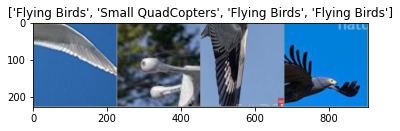

In [9]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs[0:4,:,:,:])

imshow(out, title=[class_names[int(x)] for x in classes[0:4]])

#6. Finetuning the convnet
Load a pretrained model and reset final fully connected layer.

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


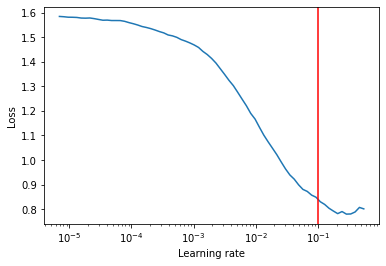

In [10]:
import torch.optim as optim
#from torch_lr_finder import LRFinder

model_ft = models.mobilenet_v2(pretrained=True)
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).

for param in model_ft.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
model_ft.classifier[1] = nn.Linear(1280, 4)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model_ft.classifier[1].parameters(), lr=1e-6, weight_decay=0.01,momentum=0.9)
lr_finder = LRFinder(model_ft, optimizer, criterion, device="cuda")
lr_finder.range_test(dataloaders['train'], end_lr=10, num_iter=100)
lr_finder.plot(show_lr=0.1) # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial stat

In [11]:
# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.classifier[1].parameters(), lr=0.01, momentum=0.09)

scheduler = optim.lr_scheduler.OneCycleLR(optimizer,
                                          max_lr=0.1, 
                                          steps_per_epoch=len(dataloaders['train']), #Training folder size/bs 
                                          epochs=25)

# 7. Train and evaluate
It should take around 15-25 min on CPU. On GPU though, it takes less than a minute.

In [12]:
model_res, plotData = train_model(model_ft, dataloaders, dataset_sizes, device, criterion, optimizer_ft, scheduler,
                       num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 0.8443 Acc: 0.6970
val Loss: 0.5014 Acc: 0.8518

Epoch 1/24
----------
train Loss: 0.5432 Acc: 0.8247
val Loss: 0.3872 Acc: 0.8820

Epoch 2/24
----------
train Loss: 0.4745 Acc: 0.8412
val Loss: 0.3459 Acc: 0.8856

Epoch 3/24
----------
train Loss: 0.4430 Acc: 0.8467
val Loss: 0.3228 Acc: 0.8872

Epoch 4/24
----------
train Loss: 0.4171 Acc: 0.8539
val Loss: 0.3078 Acc: 0.8918

Epoch 5/24
----------
train Loss: 0.4026 Acc: 0.8565
val Loss: 0.2952 Acc: 0.8963

Epoch 6/24
----------
train Loss: 0.4043 Acc: 0.8548
val Loss: 0.2899 Acc: 0.8975

Epoch 7/24
----------
train Loss: 0.3987 Acc: 0.8561
val Loss: 0.2830 Acc: 0.8979

Epoch 8/24
----------
train Loss: 0.3908 Acc: 0.8595
val Loss: 0.2806 Acc: 0.8994

Epoch 9/24
----------
train Loss: 0.3775 Acc: 0.8624
val Loss: 0.2760 Acc: 0.9032

Epoch 10/24
----------
train Loss: 0.3753 Acc: 0.8611
val Loss: 0.2710 Acc: 0.9023

Epoch 11/24
----------
train Loss: 0.3694 Acc: 0.8661
val Loss: 0.2684 Acc: 0.9027

Epoch 12/24
----------
t

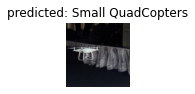

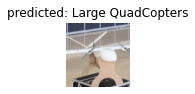

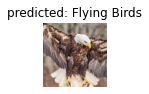

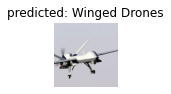

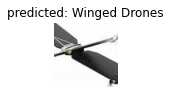

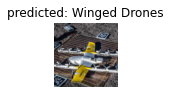

In [13]:
visualize_model(model_res, dataloaders, class_names, device)

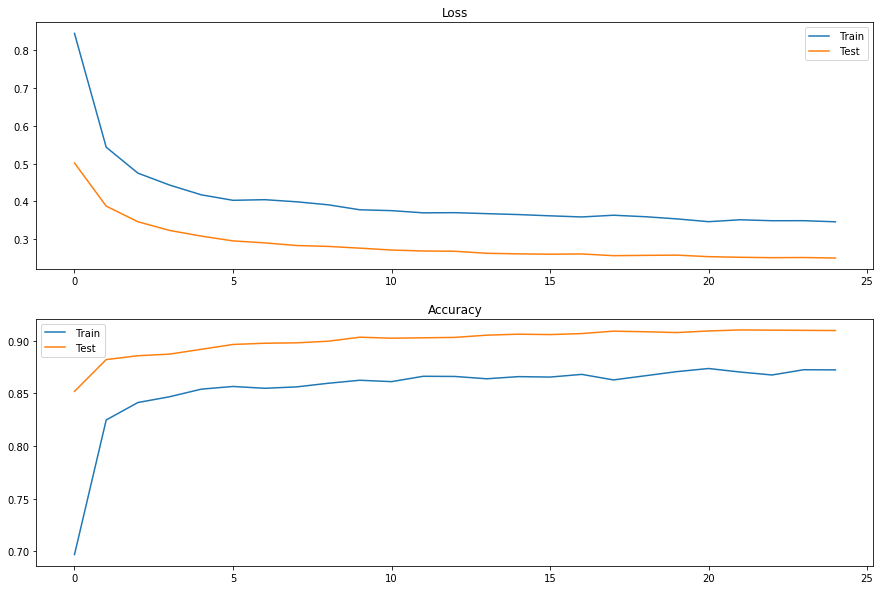

In [14]:
PlotGraph(plotData)

# 8. ConvNet as fixed feature extractor
Here, we need to freeze all the network except the final layer. We need to set requires_grad == False to freeze the parameters so that the gradients are not computed in backward().

You can read more about this in the documentation here.

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


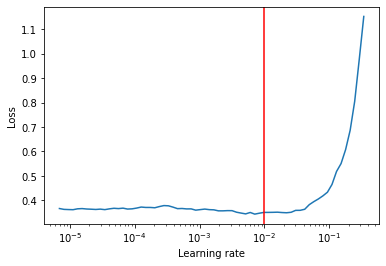

In [15]:
model_conv = model_res
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).

model_conv = model_conv.to(device)

for param in model_conv.parameters():
    param.requires_grad = True

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model_conv.parameters(), lr=1e-6, weight_decay=0.01,momentum=0.9)
lr_finder = LRFinder(model_conv, optimizer, criterion, device="cuda")
lr_finder.range_test(dataloaders['train'], end_lr=10, num_iter=100)
lr_finder.plot(show_lr=0.01) # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial stat

In [16]:
# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
scheduler = optim.lr_scheduler.OneCycleLR(optimizer_conv,
                                          max_lr=0.01, 
                                          steps_per_epoch=len(dataloaders['train']), #Training folder size/bs
                                          epochs=25,
                                          pct_start=0.2, div_factor=10, final_div_factor=100)


In [17]:
model_final, plotData = train_model(model_conv, dataloaders, dataset_sizes, device, criterion, optimizer_conv, scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.3274 Acc: 0.8770
val Loss: 0.2187 Acc: 0.9233

Epoch 1/24
----------
train Loss: 0.2655 Acc: 0.8992
val Loss: 0.1982 Acc: 0.9329

Epoch 2/24
----------
train Loss: 0.2556 Acc: 0.9069
val Loss: 0.2073 Acc: 0.9315

Epoch 3/24
----------
train Loss: 0.2298 Acc: 0.9138
val Loss: 0.1859 Acc: 0.9400

Epoch 4/24
----------
train Loss: 0.2125 Acc: 0.9220
val Loss: 0.1719 Acc: 0.9455

Epoch 5/24
----------
train Loss: 0.1982 Acc: 0.9293
val Loss: 0.1860 Acc: 0.9392

Epoch 6/24
----------
train Loss: 0.1979 Acc: 0.9284
val Loss: 0.1838 Acc: 0.9361

Epoch 7/24
----------
train Loss: 0.1814 Acc: 0.9319
val Loss: 0.1852 Acc: 0.9409

Epoch 8/24
----------
train Loss: 0.1716 Acc: 0.9374
val Loss: 0.1625 Acc: 0.9465

Epoch 9/24
----------
train Loss: 0.1507 Acc: 0.9461
val Loss: 0.1694 Acc: 0.9489

Epoch 10/24
----------
train Loss: 0.1535 Acc: 0.9441
val Loss: 0.2233 Acc: 0.9329

Epoch 11/24
----------
train Loss: 0.1453 Acc: 0.9468
val Loss: 0.1738 Acc: 0.9470

Ep

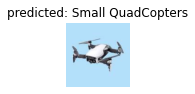

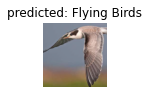

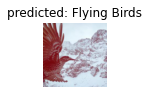

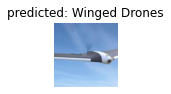

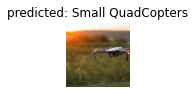

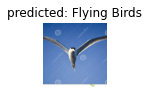

In [18]:
visualize_model(model_final, dataloaders, class_names, device)

plt.ioff()
plt.show()

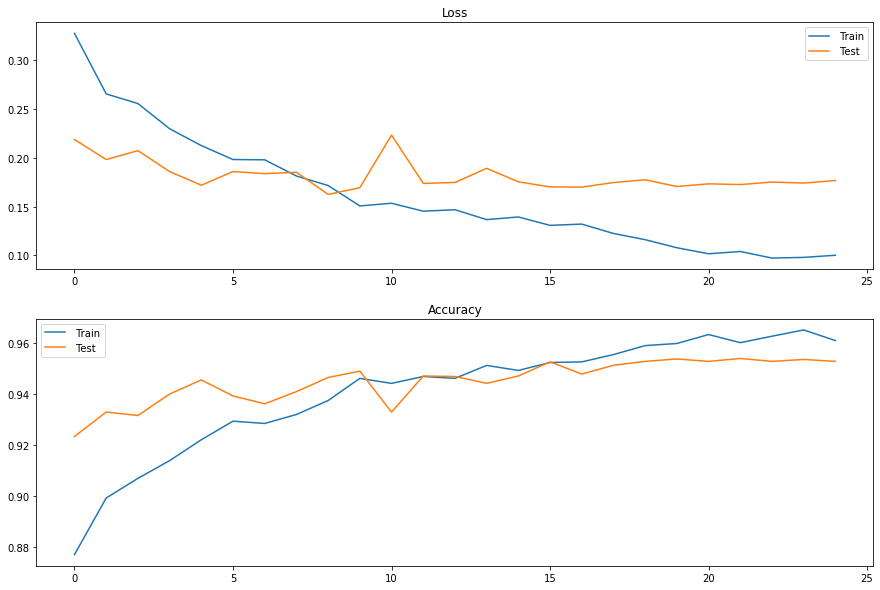

In [19]:
PlotGraph(plotData)

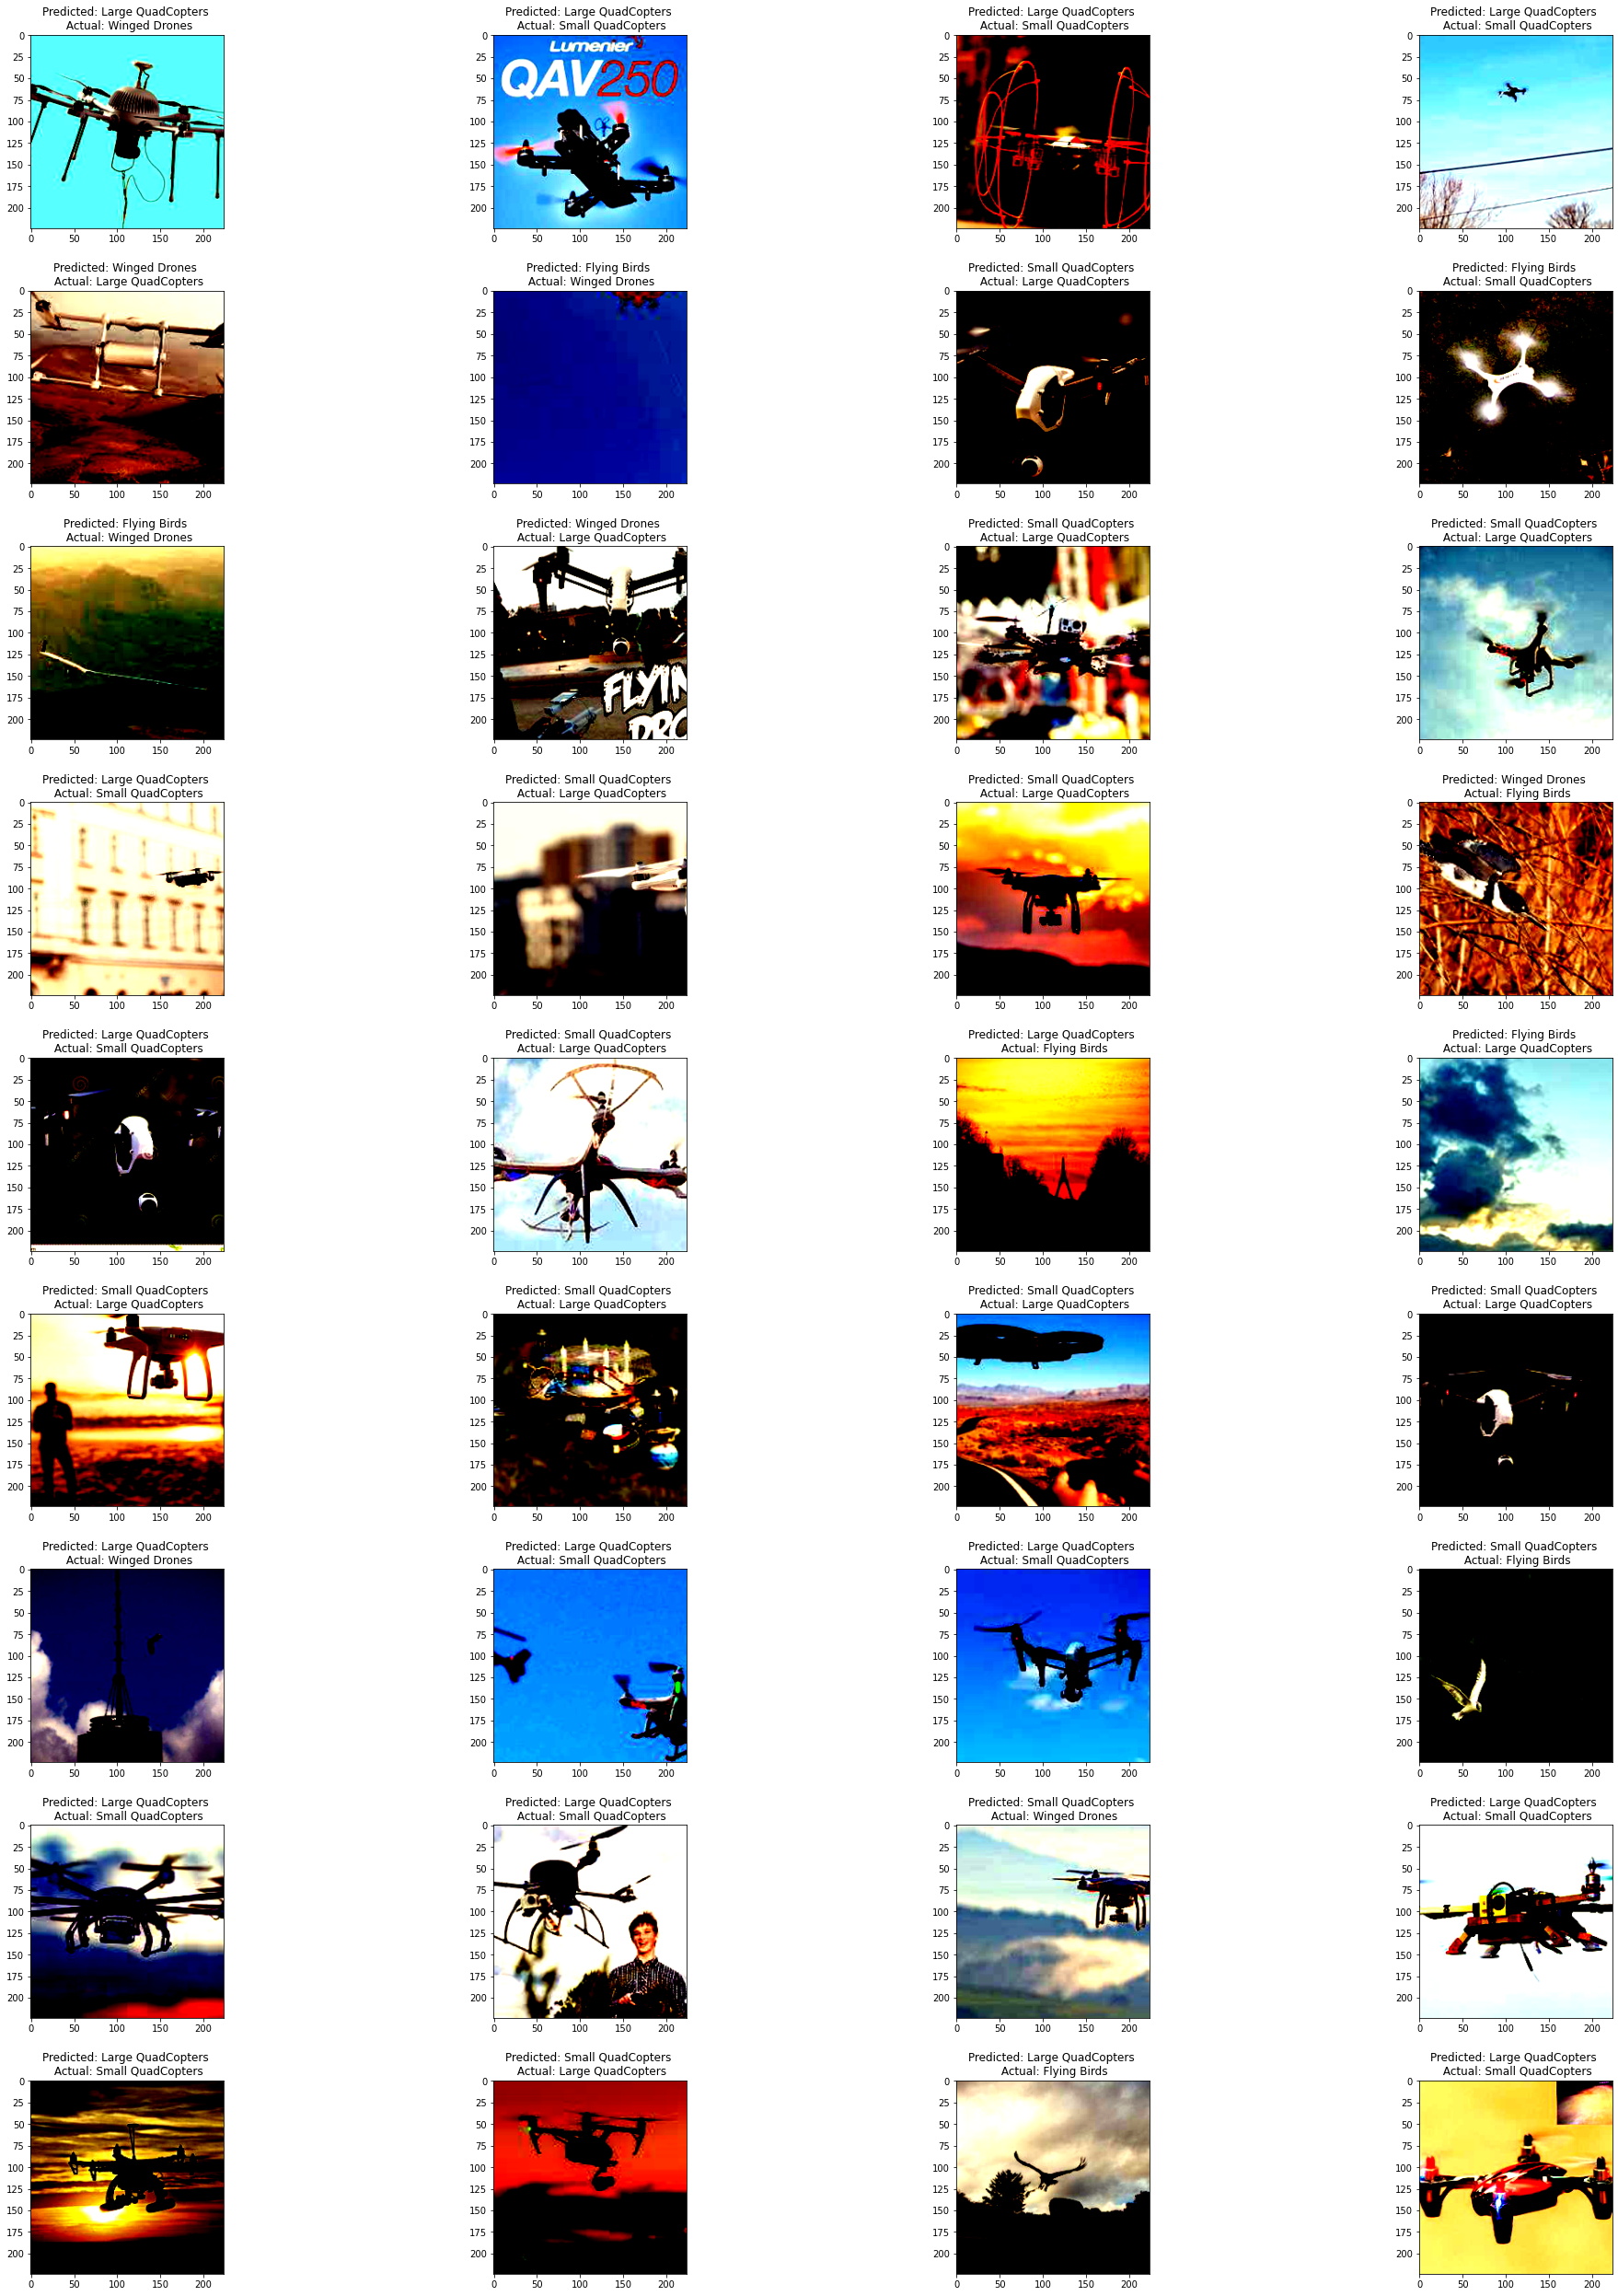

In [20]:
ShowMissclassifiedImages(model_final, dataloaders, class_names, device)

# 9. Saving Model

In [21]:
# Save GPU Model
torch.save(model_final.state_dict(), '/content/mobilenet_v2_custom_trained_gpu_v4b2.pt')

# Load CPU Model
device = torch.device('cpu')
model = models.mobilenet_v2(pretrained=False)
model.classifier[1] = nn.Linear(1280, 4)
model.load_state_dict(torch.load('/content/mobilenet_v2_custom_trained_gpu_v4b2.pt',
                                 map_location=device))

# Saving Trace Model
model.eval()
# trace model with a dummy input
traced_model = torch.jit.trace(model, torch.randn(1, 3, 224, 224))
traced_model.save('mobilenet_v2_custom_trained_v4b2.pt')